In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta
from sklearn.ensemble import IsolationForest

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [14]:
def calculate_kup1_rsi_ml(df, rsi_window=14):
    """
    机器学习增强的尾部信号因子
    使用孤立森林识别异常尾部形态
    """
    # 计算RSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    overbought = np.where(df['rsi'] > 70, 1.5, 0.5)
    
    # 基础KUP1计算
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']
    
    # 构建特征矩阵：包含价格行为和成交量特征
    features = pd.DataFrame({
        'upper_shadow': upper_shadow / df['open'],
        'body_range': (df['close'] - df['open']).abs() / df['open'],
        'vol_ratio': df['volume'] / df['volume'].rolling(20).mean(),
        'flow_ratio': df['taker_buy_volume'] / (df['volume'] + 1e-5)
    }).fillna(0)
    
    # 使用孤立森林识别异常尾部形态
    model = IsolationForest(contamination=0.1, random_state=42)
    anomalies = model.fit_predict(features)
    
    # 标记尾部异常点（因子值低且被识别为异常）
    tail_condition = (base_kup1.rank(pct=True) < 0.2) & (anomalies == -1)
    
    # 信号强化
    enhancement = np.where(tail_condition, 3.0, 1.0)
    
    return base_kup1 * overbought * enhancement * np.where(tail_condition, -1, 1)

# 因子测试

In [15]:
evaluator.set_factor(
    factor_func=calculate_kup1_rsi_ml,
    factor_name='calculate_kup1_rsi_ml'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.011563
   Rank_IC (Spearman): 0.010196
📊 信息比率:
   IR: -0.043649
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130689
   因子列: calculate_kup1_rsi_ml
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


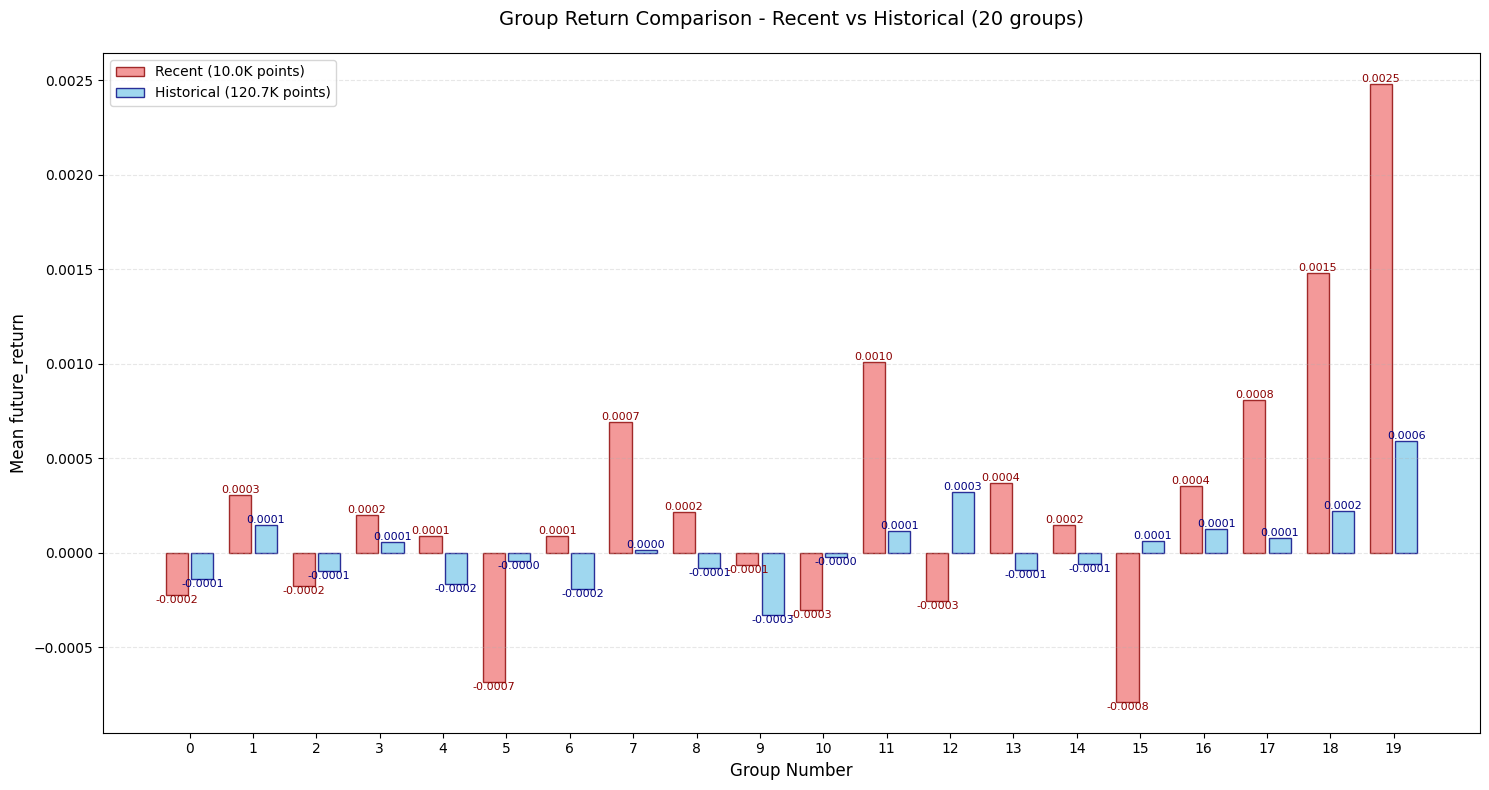

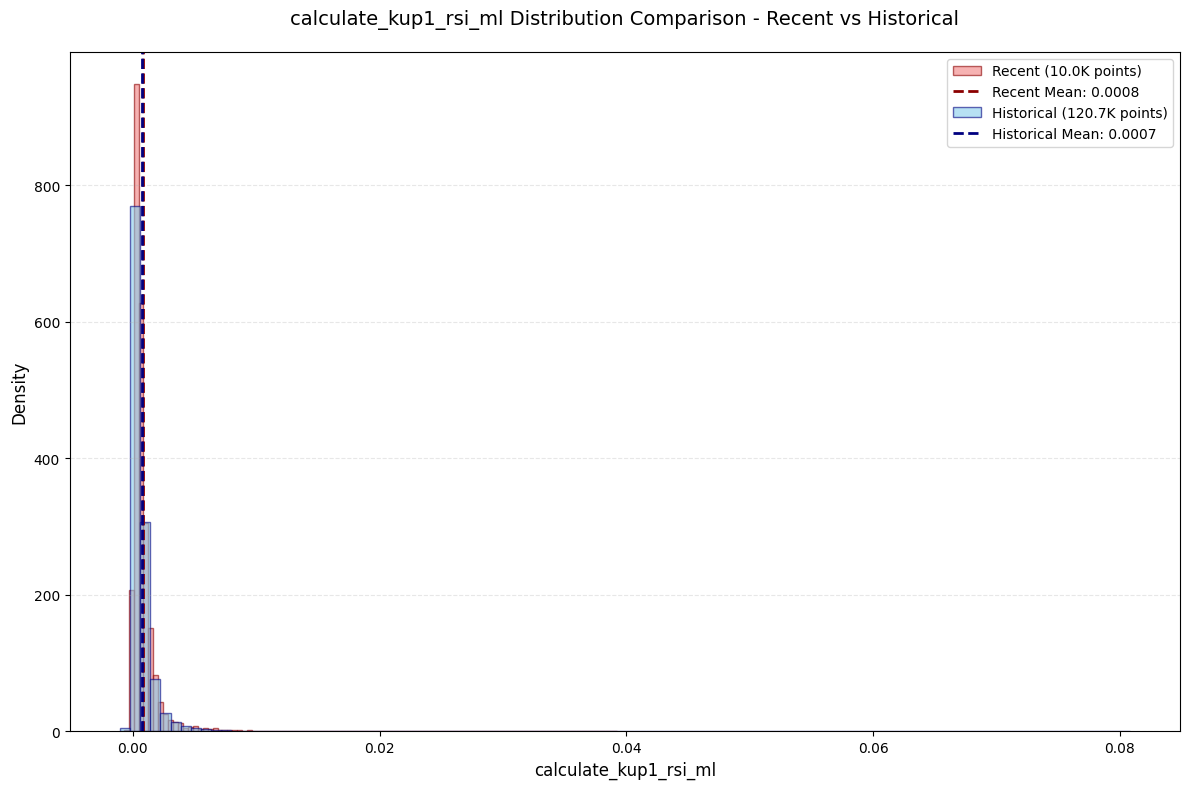

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [16]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)